# ОИАД. Лабораторная работа №4

## Классификация. Линейные модели.

**Студент:** Малиновский Егор (8 вариант)
**Целевая переменная:** `ss` (N % 8 = 0)
**Датасет:** `datasets/famcs_students.csv.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, roc_curve
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")
np.random.seed(42)
random.seed(42)

## Теоретические сведения

### 1. Наивный байесовский классификатор (Gaussian Naive Bayes)
Основан на теореме Байеса с предположением о независимости признаков:
$$ P(y|x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i|y) $$

Для непрерывных признаков предполагается нормальное распределение:
$$ P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right) $$

### 2. Метод k-ближайших соседей (k-NN)
Классификация объекта $x$ происходит по голосованию $k$ ближайших соседей из обучающей выборки.
Расстояние (обычно евклидово):
$$ d(x, x_i) = \sqrt{\sum_{j=1}^{m} (x^{(j)} - x_i^{(j)})^2} $$
Вероятность класса:
$$ P(y=c|x) = \frac{1}{k} \sum_{i \in N_k(x)} I(y_i = c) $$

### 3. Логистическая регрессия
Модель предсказывает вероятность принадлежности к положительному классу:
$$ P(y=1|x) = \sigma(w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}} $$

Обучение методом градиентного спуска (минимизация LogLoss):
$$ J(w, b) = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)] $$
Обновление весов:
$$ w := w - \alpha \frac{\partial J}{\partial w} = w - \alpha \frac{1}{N} X^T (\hat{y} - y) $$

### Метрики качества
* **Accuracy** (Точность): $\frac{TP + TN}{TP + TN + FP + FN}$
* **Precision** (Точность): $\frac{TP}{TP + FP}$
* **Recall** (Полнота): $\frac{TP}{TP + FN}$
* **F1-score**: $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$


## Подготовка данных

In [2]:
# Загрузка данных
try:
    df = pd.read_csv('../../datasets/famcs_students.csv.csv')
except FileNotFoundError:
    df = pd.read_csv('datasets/famcs_students.csv.csv')

print(f"Размер датасета: {df.shape}")
df.head()

Размер датасета: (127, 25)


,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [3]:
# Целевая переменная
target_col = 'ss'

# Преобразование целевой переменной в бинарный формат
df['target'] = df[target_col].map({'Нет': 0, 'Да': 1})

print(f"Распределение целевой переменной ({target_col}):")
print(df['target'].value_counts())

# Выбор признаков (X)
# Используем числовые и бинарные признаки
# Преобразуем категориальные признаки в бинарные/числовые

# 1. score (числовой)
# 2. miss (числовой)
# 3. age (числовой)
# 4. sex (категориальный -> бинарный)
# 5. weekend_study (категориальный -> бинарный)
# 6. bad_sleep (категориальный -> бинарный)

df['sex_bin'] = df['sex'].map({'Ж': 0, 'М': 1})
df['weekend_study_bin'] = df['weekend_study'].map({'Нет': 0, 'Да': 1})
df['bad_sleep_bin'] = df['bad_sleep'].map({'Нет': 0, 'Да': 1})

features = ['score', 'miss', 'age', 'sex_bin', 'weekend_study_bin', 'bad_sleep_bin']
X = df[features].values
y = df['target'].values

# Обработка пропусков (если есть)
print(f"\nПропуски в данных:\n{df[features].isnull().sum()}")
# Заполним пропуски средним/модой если есть, или удалим. В этом датасете вроде нет, но на всякий случай:
for i, col in enumerate(features):
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
        
X = df[features].values

print(f"\nВыбранные признаки: {features}")

Распределение целевой переменной (ss):
target
0    113
1     14
Name: count, dtype: int64

Пропуски в данных:
score                0
miss                 0
age                  0
sex_bin              0
weekend_study_bin    0
bad_sleep_bin        0
dtype: int64

Выбранные признаки: ['score', 'miss', 'age', 'sex_bin', 'weekend_study_bin', 'bad_sleep_bin']


In [4]:
# Разделение данных: Train (70%), Val (15%), Test (15%)
# Сначала отделим Test (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Теперь отделим Validation (15% от исходного -> ~17.6% от оставшихся 85%)
# 0.15 / 0.85 ≈ 0.1765
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42, stratify=y_train_full)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (88, 6), Val: (19, 6), Test: (20, 6)


In [5]:
# Нормализация данных (MinMax или StandardScaler) - важно для k-NN и Logistic Regression
# Реализуем простую стандартизацию (Z-score)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_scaled = (X_train - mean) / (std + 1e-8)
X_val_scaled = (X_val - mean) / (std + 1e-8)
X_test_scaled = (X_test - mean) / (std + 1e-8)

## 0. Тривиальный классификатор

In [6]:
class TrivialClassifier:
    def fit(self, X, y):
        self.mode = pd.Series(y).mode()[0]
    
    def predict(self, X):
        return np.full(X.shape[0], self.mode)
    
    def predict_proba(self, X):
        # Возвращаем вероятность класса 1. Если мода 1, то 1.0, иначе 0.0 (упрощенно)
        # Или честнее: частота класса 1 в обучении
        return np.full(X.shape[0], self.mode)

trivial_model = TrivialClassifier()
trivial_model.fit(X_train, y_train)
y_pred_trivial = trivial_model.predict(X_test)

print(f"Accuracy (Trivial): {accuracy_score(y_test, y_pred_trivial):.4f}")

Accuracy (Trivial): 0.9000


## 1. Наивный байесовский классификатор (Gaussian NB)

In [8]:
class MyGaussianNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9,  # добавляем epsilon для стабильности
                'prior': X_c.shape[0] / X.shape[0]
            }
            
    def _log_pdf(self, class_idx, x):
        mean = self.parameters[class_idx]['mean']
        var = self.parameters[class_idx]['var']
        numerator = -((x - mean) ** 2) / (2 * var)
        denominator = -0.5 * np.log(2 * np.pi * var)
        return numerator + denominator

    def predict_proba(self, X):
        posteriors = []
        for x in X:
            posterior = {}
            for c in self.classes:
                prior = np.log(self.parameters[c]['prior'])
                conditional = np.sum(self._log_pdf(c, x))
                posterior[c] = prior + conditional
            posteriors.append(posterior)
        
        # Нормализация для получения вероятностей (softmax для log-prob)
        probs = []
        for p in posteriors:
            # p = {0: log_prob0, 1: log_prob1}
            # P(1) = exp(log_prob1) / (exp(log_prob0) + exp(log_prob1))
            # Для стабильности вычитаем max
            max_log = max(p.values())
            exp_sum = sum(np.exp(v - max_log) for v in p.values())
            prob_1 = np.exp(p[1] - max_log) / exp_sum
            probs.append(prob_1)
            
        return np.array(probs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)

nb_model = MyGaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

## 2. Метод k-ближайших соседей (k-NN)

Лучший k: 3 с Accuracy на валидации: 0.9474


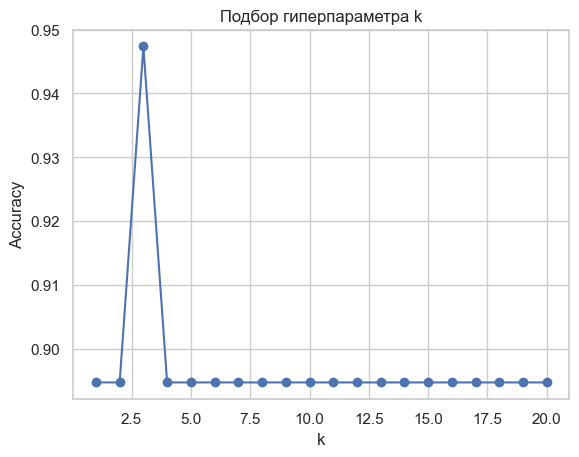

In [9]:
class MyKNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))
    
    def predict(self, X):
        y_pred = [self._predict_one(x) for x in X]
        return np.array(y_pred)
    
    def _predict_one(self, x):
        # Вычисляем расстояния до всех точек
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        # Сортируем и берем k ближайших
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Возвращаем самый частый класс
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
    
    def predict_proba(self, X):
        probs = []
        for x in X:
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            prob_1 = np.mean(k_nearest_labels) # Доля единиц среди соседей
            probs.append(prob_1)
        return np.array(probs)

# Подбор k на валидации
best_k = 1
best_score = 0
history_k = []
history_score = []

for k in range(1, 21):
    knn = MyKNN(k=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_val = knn.predict(X_val_scaled)
    score = accuracy_score(y_val, y_pred_val)
    history_k.append(k)
    history_score.append(score)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Лучший k: {best_k} с Accuracy на валидации: {best_score:.4f}")

plt.plot(history_k, history_score, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Подбор гиперпараметра k')
plt.show()

# Обучение лучшей модели
knn_model = MyKNN(k=best_k)
knn_model.fit(X_train_scaled, y_train)

## 3. Логистическая регрессия

Лучший порог (по F1): 0.1000


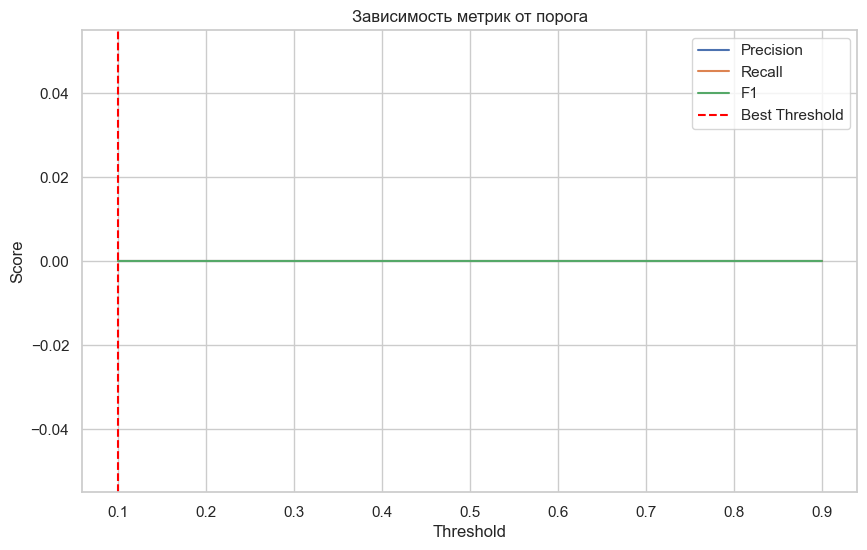

In [10]:
class MyLogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_predicted_cls = [1 if i > threshold else 0 for i in self.predict_proba(X)]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

log_reg = MyLogisticRegression(lr=0.1, n_iters=2000)
log_reg.fit(X_train_scaled, y_train)

# Подбор порога
val_probs = log_reg.predict_proba(X_val_scaled)
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (val_probs >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_t))
    precisions.append(precision_score(y_val, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_t))

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"Лучший порог (по F1): {best_threshold:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1')
plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Зависимость метрик от порога')
plt.show()

## 4. Оценка качества


--- Trivial Classifier ---
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
ROC-AUC: 0.5000


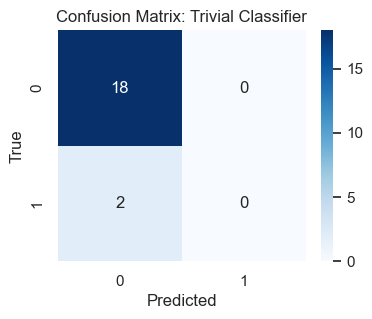


--- Naive Bayes ---
Accuracy: 0.3000
Precision: 0.1250
Recall: 1.0000
ROC-AUC: 0.5833


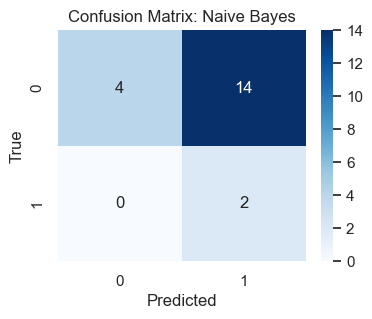


--- k-NN (k=3) ---
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
ROC-AUC: 0.3611


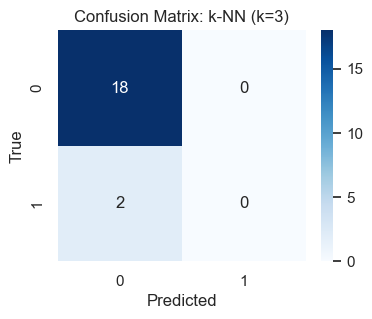


--- Logistic Regression (thresh=0.10) ---
Accuracy: 0.6000
Precision: 0.0000
Recall: 0.0000
ROC-AUC: 0.4722


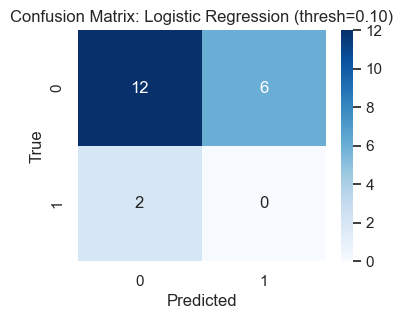

In [11]:
def evaluate_model(name, y_true, y_pred, y_proba=None):
    print(f"\n--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 1. Trivial
evaluate_model("Trivial Classifier", y_test, y_pred_trivial, trivial_model.predict_proba(X_test))

# 2. Naive Bayes
evaluate_model("Naive Bayes", y_test, nb_model.predict(X_test), nb_model.predict_proba(X_test))

# 3. k-NN
evaluate_model(f"k-NN (k={best_k})", y_test, knn_model.predict(X_test_scaled), knn_model.predict_proba(X_test_scaled))

# 4. Logistic Regression
y_pred_log_best = log_reg.predict(X_test_scaled, threshold=best_threshold)
evaluate_model(f"Logistic Regression (thresh={best_threshold:.2f})", y_test, y_pred_log_best, log_reg.predict_proba(X_test_scaled))

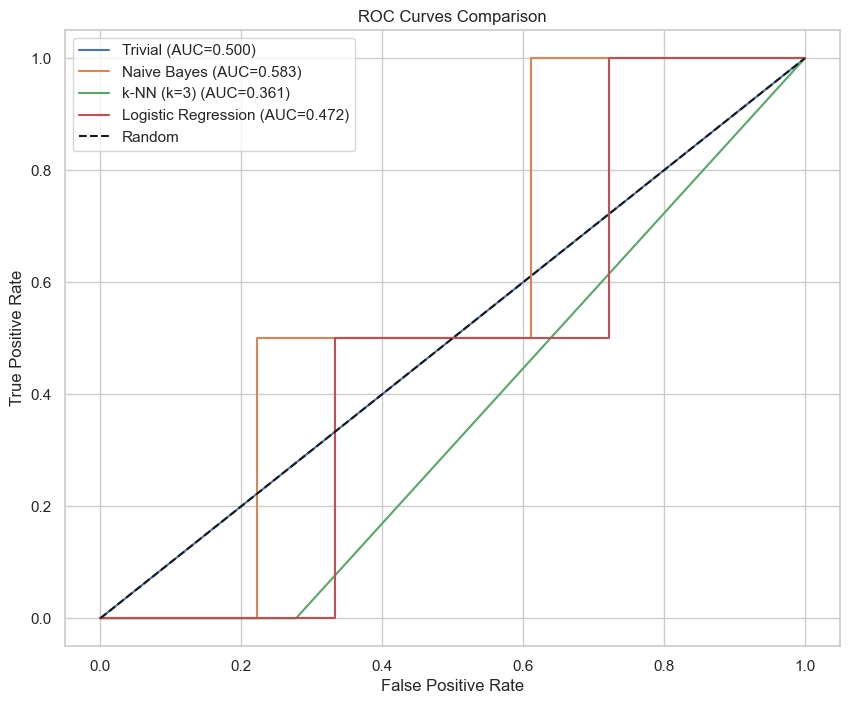

In [12]:
# ROC Curves comparison
plt.figure(figsize=(10, 8))

models = [
    ("Trivial", trivial_model.predict_proba(X_test)),
    ("Naive Bayes", nb_model.predict_proba(X_test)),
    (f"k-NN (k={best_k})", knn_model.predict_proba(X_test_scaled)),
    ("Logistic Regression", log_reg.predict_proba(X_test_scaled))
]

for name, y_proba in models:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()